In [1]:
import qiskit
print(qiskit.__qiskit_version__)

/tmp/ipykernel_19991/3443674879.py:2: DeprecationWarning: qiskit.__qiskit_version__ is deprecated since Qiskit Terra 0.25.0, and will be removed 3 months or more later. Instead, you should use qiskit.__version__. The other packages listed in theformer qiskit.__qiskit_version__ have their own __version__ module level dunder, as standard in PEP 8.
  print(qiskit.__qiskit_version__)


{'qiskit': '0.46.3', 'qiskit-aer': '0.12.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}


In [ ]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems import MaximumCut, NumberPartition

#import the QAOA workflow model
from openqaoa import QAOA
from qaoa_components.variational_parameters.variational_baseparams import QAOAVariationalBaseParams
#import method to specify the device
from openqaoa.backends import create_device

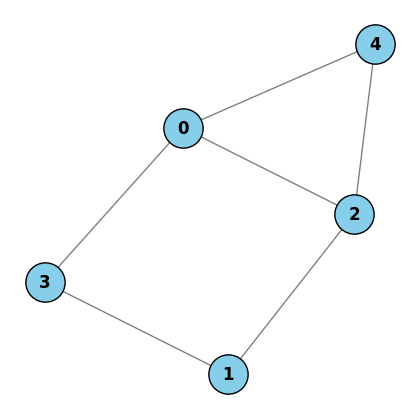

In [2]:
# Re-import necessary libraries due to execution state reset
import networkx as nx
import matplotlib.pyplot as plt

# Define graph parameters
nodes = 5
edge_probability = 0.6

# Generate random graph
g = nx.generators.fast_gnp_random_graph(n=nodes, p=edge_probability, seed=42)

# Improve graph aesthetics
plt.figure(figsize=(4, 4))  # Set figure size
pos = nx.spring_layout(g, seed=42)  # Use spring layout for better spacing
nx.draw(
    g, pos, with_labels=True, node_color="skyblue", edge_color="gray", 
    node_size=800, font_size=12, font_weight="bold", linewidths=1, edgecolors="black"
)

# Display the improved graph
# plt.title("Improved Random Graph Visualization")
plt.show()


In [2]:
from openqaoa.qaoa_components.variational_parameters.variational_baseparams import QAOAVariationalBaseParams
from openqaoa.qaoa_components.ansatz_constructor import QAOADescriptor
import numpy as np
from typing import Dict, Tuple

class MockQAOADescriptor:
    """Mock QAOADescriptor to test QAOAVariationalBaseParams."""

    def __init__(self, p: int = 2):
        """
        Initialize the Mock QAOA Descriptor with valid parameters.

        Parameters:
        -----------
        p: int
            The number of QAOA layers (default=2).
        """
        self.p = p  # QAOA depth (number of layers)
        
        # Define cost Hamiltonian coefficients
        self.cost_hamiltonian = self  # Self-reference for compatibility
        self.cost_single_qubit_coeffs = np.array([-79.0, -62.0, -63.0])  # h_i terms
        self.cost_pair_qubit_coeffs: Dict[Tuple[int, int], float] = {
            (0, 1): 60.0,
            (0, 2): 60.0,
            (1, 2): 40.0
        }  # J_ij terms

        # Define mixer Hamiltonian coefficients (X-mixing terms)
        self.mixer_hamiltonian = self
        self.mixer_single_qubit_coeffs = np.array([1.0, 1.0, 1.0])  # Default uniform coefficients
        self.mixer_pair_qubit_coeffs = {}

    @property
    def cost_1q_coeffs(self):
        """Returns single-qubit coefficients for cost Hamiltonian."""
        return self.cost_single_qubit_coeffs

    @property
    def cost_2q_coeffs(self):
        """Returns pair-qubit coefficients for cost Hamiltonian."""
        return self.cost_pair_qubit_coeffs

    @property
    def mixer_1q_coeffs(self):
        """Returns single-qubit coefficients for the mixer Hamiltonian."""
        return self.mixer_single_qubit_coeffs

    @property
    def mixer_2q_coeffs(self):
        """Returns pair-qubit coefficients for the mixer Hamiltonian."""
        return self.mixer_pair_qubit_coeffs

class QAOAVariationalParams(QAOAVariationalBaseParams):
    """Concrete implementation of QAOAVariationalBaseParams."""

    def __init__(self, qaoa_descriptor: MockQAOADescriptor):
        super().__init__(qaoa_descriptor)
        self.gammas = np.ones(self.p)  # Example initialization for gamma parameters

    @property
    def cost_1q_angles(self) -> np.ndarray:
        """Compute the rotation angles for single-qubit Z-terms."""
        return 2 * np.outer(self.gammas, self.cost_1q_coeffs)

    @property
    def cost_2q_angles(self) -> np.ndarray:
        """Compute the rotation angles for two-qubit ZZ terms."""
        return 2 * np.outer(self.gammas, list(self.cost_2q_coeffs.values()))

# Initialize the descriptor and parameters
qaoa_descriptor = MockQAOADescriptor(p=2)
qaoa_params = QAOAVariationalParams(qaoa_descriptor)

# Compute angles
rz_angles = qaoa_params.cost_1q_angles
rzz_angles = qaoa_params.cost_2q_angles

# Print results
print("Cost 1Q Angles (RZ Rotations for Each Layer):")
print(rz_angles)

print("\nCost 2Q Angles (RZZ Rotations for Each Layer):")
print(rzz_angles)

# Initialize the QAOA parameters object with p=2
qaoa_descriptor = MockQAOADescriptor(p=2)
qaoa_params = QAOAVariationalParams(qaoa_descriptor)

# Compute cost Hamiltonian angles
rz_angles = qaoa_params.cost_1q_angles
rzz_angles = qaoa_params.cost_2q_angles

# Print results
print("Cost 1Q Angles (RZ Rotations for Each Layer):")
print(rz_angles)

print("\nCost 2Q Angles (RZZ Rotations for Each Layer):")
print(rzz_angles)


Cost 1Q Angles (RZ Rotations for Each Layer):
[[-158. -124. -126.]
 [-158. -124. -126.]]

Cost 2Q Angles (RZZ Rotations for Each Layer):
[[120. 120.  80.]
 [120. 120.  80.]]
Cost 1Q Angles (RZ Rotations for Each Layer):
[[-158. -124. -126.]
 [-158. -124. -126.]]

Cost 2Q Angles (RZZ Rotations for Each Layer):
[[120. 120.  80.]
 [120. 120.  80.]]


In [6]:
import numpy as np
from typing import Dict, Tuple, List

class KnapsackQUBO:
    """Class to normalize QUBO coefficients for a small Knapsack Hamiltonian."""

    def __init__(self, qubo_terms: List[Tuple], qubo_weights: List[float]):
        """
        Initialize with QUBO terms and weights.

        Parameters:
        -----------
        qubo_terms : list of tuples
            List of QUBO terms where (i,) represents single-qubit and (i, j) represents two-qubit interactions.
        qubo_weights : list of floats
            List of corresponding coefficients for each term.
        """
        self.qubo_terms = qubo_terms
        self.qubo_weights = np.array(qubo_weights)

        # Extract single-qubit and two-qubit terms correctly
        self.single_qubit_terms = {term[0]: w for term, w in zip(qubo_terms, qubo_weights) if len(term) == 1}
        self.two_qubit_terms = {tuple(term): w for term, w in zip(qubo_terms, qubo_weights) if len(term) == 2}

    def normalize_coefficients(self):
        """Normalize coefficients into [0, π] for single-qubit terms and [0, 2π] for two-qubit terms."""
        max_single = max(abs(w) for w in self.single_qubit_terms.values()) if self.single_qubit_terms else 1
        max_two = max(abs(w) for w in self.two_qubit_terms.values()) if self.two_qubit_terms else 1

        self.normalized_single_qubit = {
            i: abs(w) / max_single * np.pi for i, w in self.single_qubit_terms.items()
        }
        self.normalized_two_qubit = {
            (i, j): abs(w) / max_two * 2 * np.pi for (i, j), w in self.two_qubit_terms.items()
        }

    def print_normalized(self):
        """Print normalized coefficients."""
        print("Normalized Single-Qubit Coefficients (Range: [0, π]):")
        for i, w in self.normalized_single_qubit.items():
            print(f"Qubit {i}: {w:.3f}")

        print("\nNormalized Two-Qubit Coefficients (Range: [0, 2π]):")
        for (i, j), w in self.normalized_two_qubit.items():
            print(f"Qubit {i}-{j}: {w:.3f}")

# Example Hamiltonian for Knapsack
qubo_terms = [(0,), (0, 1), (0, 2)]  # Single qubit Z_0 and Two-qubit interactions Z_0Z_1, Z_0Z_2
qubo_weights = [-0.5, 0.7, 1.2]  # Corresponding coefficients

# Create QUBO normalizer and compute normalized values
knapsack_qubo = KnapsackQUBO(qubo_terms, qubo_weights)
knapsack_qubo.normalize_coefficients()
knapsack_qubo.print_normalized()


Normalized Single-Qubit Coefficients (Range: [0, π]):
Qubit 0: 3.142

Normalized Two-Qubit Coefficients (Range: [0, 2π]):
Qubit 0-1: 3.665
Qubit 0-2: 6.283


In [7]:
import numpy as np
from typing import Dict, Tuple, List

class KnapsackQUBO:
    """Class to normalize QUBO coefficients for a small Knapsack Hamiltonian."""

    def __init__(self, qubo_terms: List[Tuple], qubo_weights: List[float]):
        """
        Initialize with QUBO terms and weights.

        Parameters:
        -----------
        qubo_terms : list of tuples
            List of QUBO terms where (i,) represents single-qubit and (i, j) represents two-qubit interactions.
        qubo_weights : list of floats
            List of corresponding coefficients for each term.
        """
        self.qubo_terms = qubo_terms
        self.qubo_weights = np.array(qubo_weights)

        # Extract single-qubit and two-qubit terms correctly
        self.single_qubit_terms = {term[0]: w for term, w in zip(qubo_terms, qubo_weights) if len(term) == 1}
        self.two_qubit_terms = {tuple(term): w for term, w in zip(qubo_terms, qubo_weights) if len(term) == 2}

    def normalize_coefficients(self):
        """Normalize coefficients into [0, π] for single-qubit terms and [0, 2π] for two-qubit terms."""
        max_single = max(abs(w) for w in self.single_qubit_terms.values()) if self.single_qubit_terms else 1
        max_two = max(abs(w) for w in self.two_qubit_terms.values()) if self.two_qubit_terms else 1

        self.normalized_single_qubit = {
            i: abs(w) / max_single * np.pi for i, w in self.single_qubit_terms.items()
        }
        self.normalized_two_qubit = {
            (i, j): abs(w) / max_two * 2 * np.pi for (i, j), w in self.two_qubit_terms.items()
        }

    def print_normalized(self, format_type="pi"):
        """
        Print normalized coefficients in the desired format.

        Parameters:
        -----------
        format_type : str
            "pi"  → prints as multiples of π
            "deg" → prints in degrees
        """
        print("Normalized Single-Qubit Coefficients (Range: [0, π]):")
        for i, w in self.normalized_single_qubit.items():
            if format_type == "pi":
                print(f"Qubit {i}: {w/np.pi:.3f}π")
            elif format_type == "deg":
                print(f"Qubit {i}: {w * 180 / np.pi:.2f}°")

        print("\nNormalized Two-Qubit Coefficients (Range: [0, 2π]):")
        for (i, j), w in self.normalized_two_qubit.items():
            if format_type == "pi":
                print(f"Qubit {i}-{j}: {w/(2*np.pi):.3f} × 2π")
            elif format_type == "deg":
                print(f"Qubit {i}-{j}: {w * 180 / np.pi:.2f}°")

# Example Hamiltonian for Knapsack
qubo_terms = [(0,), (0, 1), (0, 2)]  # Single qubit Z_0 and Two-qubit interactions Z_0Z_1, Z_0Z_2
qubo_weights = [-0.5, 0.7, 1.2]  # Corresponding coefficients

# Create QUBO normalizer and compute normalized values
knapsack_qubo = KnapsackQUBO(qubo_terms, qubo_weights)
knapsack_qubo.normalize_coefficients()

# Print in multiples of π
print("### Angles in Multiples of π ###")
knapsack_qubo.print_normalized(format_type="pi")

# Print in degrees
print("\n### Angles in Degrees ###")
knapsack_qubo.print_normalized(format_type="deg")


### Angles in Multiples of π ###
Normalized Single-Qubit Coefficients (Range: [0, π]):
Qubit 0: 1.000π

Normalized Two-Qubit Coefficients (Range: [0, 2π]):
Qubit 0-1: 0.583 × 2π
Qubit 0-2: 1.000 × 2π

### Angles in Degrees ###
Normalized Single-Qubit Coefficients (Range: [0, π]):
Qubit 0: 180.00°

Normalized Two-Qubit Coefficients (Range: [0, 2π]):
Qubit 0-1: 210.00°
Qubit 0-2: 360.00°


(<Figure size 1000x600 with 1 Axes>, <Axes: >)

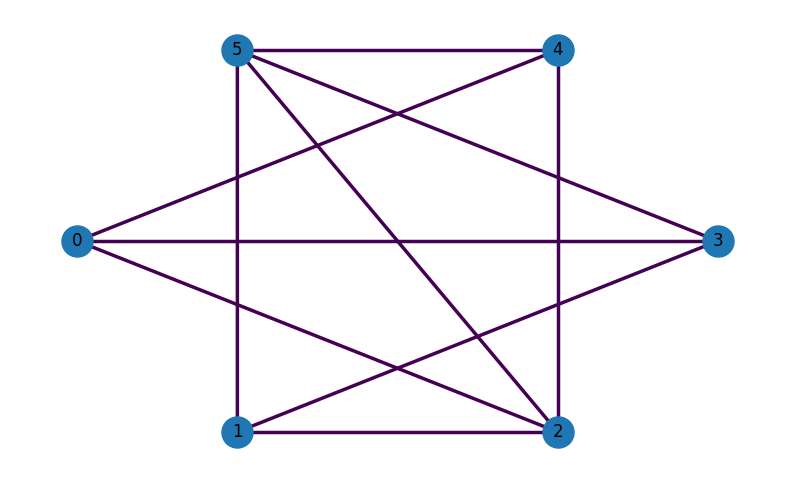

In [3]:
nodes = 6
edge_probability = 0.6
g = nx.generators.fast_gnp_random_graph(n=nodes, p=edge_probability, seed=42)

# import graph plotter from openqaoa
from openqaoa.utilities import plot_graph
plot_graph(g)

In [4]:
# Use the MaximumCut class to instantiate the problem.
maxcut_prob = MaximumCut(g)

# The property `qubo` translates the problem into a binary Qubo problem.
# The binary values can be access via the `asdict()` method.
maxcut_qubo = maxcut_prob.qubo

/global/homes/g/gzquse/.local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


In [5]:
pprint(maxcut_qubo.asdict())

{'constant': 0,
 'metadata': {},
 'n': 6,
 'problem_instance': {'G': {'directed': False,
                            'graph': {},
                            'links': [{'source': 0, 'target': 2},
                                      {'source': 0, 'target': 3},
                                      {'source': 0, 'target': 4},
                                      {'source': 1, 'target': 2},
                                      {'source': 1, 'target': 3},
                                      {'source': 1, 'target': 5},
                                      {'source': 2, 'target': 4},
                                      {'source': 2, 'target': 5},
                                      {'source': 3, 'target': 5},
                                      {'source': 4, 'target': 5}],
                            'multigraph': False,
                            'nodes': [{'id': 0},
                                      {'id': 1},
                                      {'id': 2},
             

In [6]:
hamiltonian = maxcut_qubo.hamiltonian

# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -6.0, Solution: ['001110', '110001']


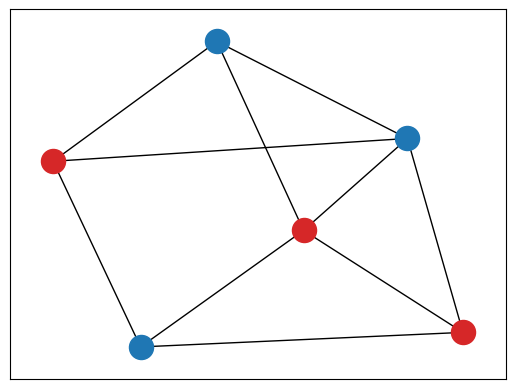

In [7]:
#plot the solution on graph
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos)

In [ ]:

# initialize model with default configurations
q = QAOA()

In [9]:
# optionally configure the following properties of the model

# device
qiskit_device = create_device(location='local', name='qiskit.statevector_simulator')
q.set_device(qiskit_device)

# circuit properties
q.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

In [14]:
q.compile(maxcut_qubo)

In [21]:
q.asdict()
# optimized_angles = opt_results.optimized['angles']
# variational_params.update_from_raw(optimized_angles)
# optimized_circuit = q.backend.qaoa_circuit(variational_params)

{'header': {'atomic_id': '57fc038f-4218-4266-816a-1441c7e8fc7a',
  'experiment_id': 'd95f8164-98df-4d03-a170-7e4682935aa2',
  'project_id': None,
  'algorithm': 'qaoa',
  'description': None,
  'run_by': None,
  'provider': None,
  'target': 'qiskit.statevector_simulator',
  'cloud': 'local',
  'client': None,
  'execution_time_start': None,
  'execution_time_end': None,
  'metadata': {'qubit_number': 6,
   'p': 2,
   'param_type': 'standard',
   'init_type': 'rand',
   'optimizer_method': 'nelder-mead',
   'problem_type': 'maximum_cut',
   'n_shots': 100}},
 'data': {'exp_tags': {'qubit_number': 6,
   'p': 2,
   'param_type': 'standard',
   'init_type': 'rand',
   'optimizer_method': 'nelder-mead'},
  'input_problem': {'terms': [[0, 2],
    [0, 3],
    [0, 4],
    [1, 2],
    [1, 3],
    [1, 5],
    [2, 4],
    [2, 5],
    [3, 5],
    [4, 5]],
   'weights': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
   'constant': 0,
   'n': 6,
   'problem_instance': {'problem_type': 'maximum

In [13]:
q.optimize()

In [14]:
opt_results = q.result

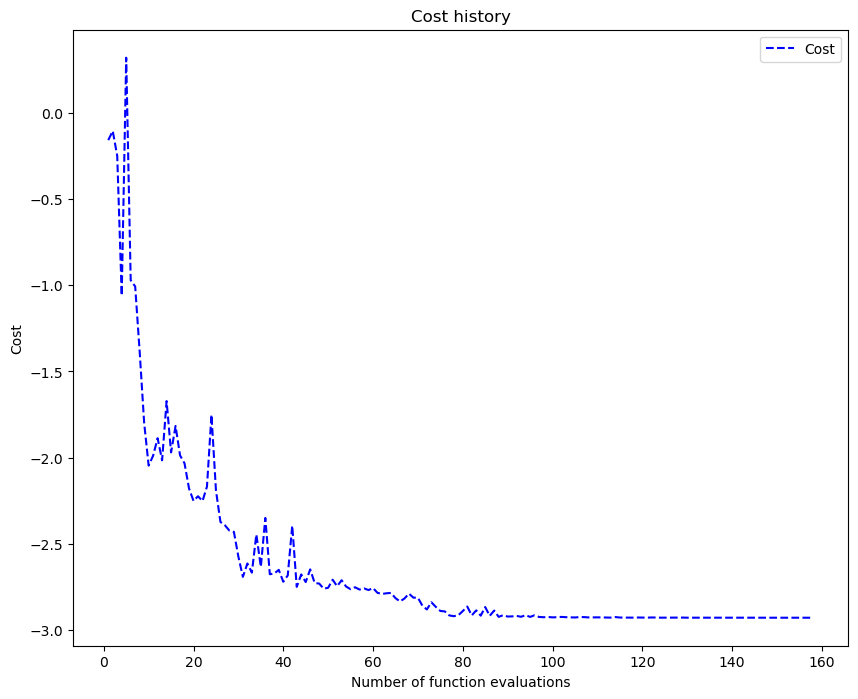

In [15]:
# print the cost history
fig, ax = opt_results.plot_cost()

In [16]:
# prints a large output (commented by default)
# pprint(opt_results.intermediate)

In [17]:
pprint(opt_results.optimized)

{'angles': [0.334208590447, 0.162236336418, 3.384764508344, 1.169470117854],
 'cost': -2.92661707383,
 'eval_number': 149,
 'job_id': '63007ce0-50cd-4a0a-833a-5cee4def11fc',
 'measurement_outcomes': array([-0.00202017-0.00158702j,  0.03568494-0.00288594j,
        0.03992697-0.0406237j , -0.02982872-0.11903726j,
       -0.00137261+0.02911856j,  0.02007021+0.09187751j,
        0.02237362+0.05542671j, -0.11145075-0.16701401j,
        0.03568494-0.00288594j,  0.04494713-0.04350448j,
        0.02117557+0.01487429j,  0.0195043 +0.11253449j,
        0.14862093+0.07911417j, -0.11312667-0.11650081j,
       -0.13267239-0.07543539j,  0.02237362+0.05542671j,
        0.03992697-0.0406237j ,  0.02117557+0.01487429j,
       -0.00394371-0.07650543j,  0.21095602+0.11053102j,
        0.00080527+0.01814677j,  0.00302224-0.07113533j,
       -0.11312667-0.11650081j,  0.02007021+0.09187751j,
       -0.02982872-0.11903726j,  0.0195043 +0.11253449j,
        0.21095602+0.11053102j, -0.13627929-0.06422549j,
   

In [18]:
variational_params = q.optimizer.variational_params

In [19]:
#create the optimized QAOA circuit for qiskit backend
optimized_angles = opt_results.optimized['angles']
variational_params.update_from_raw(optimized_angles)
optimized_circuit = q.backend.qaoa_circuit(variational_params)

#print the optimized QAOA circuit for qiskit backend
optimized_circuit.draw()

┌───┐                                                    ┌──────────────┐»
q1_0: ┤ H ├─■────────────■─────────────────────────■───────────┤ Rx(-0.66842) ├»
      ├───┤ │            │                         │           └──────────────┘»
q1_1: ┤ H ├─┼────────────┼────────────■────────────┼─────────────■─────────────»
      ├───┤ │ZZ(6.7695)  │            │ZZ(6.7695)  │             │             »
q1_2: ┤ H ├─■────────────┼────────────■────────────┼─────────────┼─────────────»
      ├───┤              │ZZ(6.7695)               │             │ZZ(6.7695)   »
q1_3: ┤ H ├──────────────■─────────────────────────┼─────────────■─────────────»
      ├───┤                                        │ZZ(6.7695)                 »
q1_4: ┤ H ├────────────────────────────────────────■───────────────────────────»
      ├───┤                                                                    »
q1_5: ┤ H ├────────────────────────────────────────────────────────────────────»
      └───┘                                                                    »
«                                                                »
«q1_0: ──────────────────────────────────────────────────────────»
«                   ┌──────────────┐                             »
«q1_1: ─■───────────┤ Rx(-0.66842) ├─────────────────────────────»
«       │           └──────────────┘             ┌──────────────┐»
«q1_2: ─┼─────────────■──────────────■───────────┤ Rx(-0.66842) ├»
«       │             │              │           └──────────────┘»
«q1_3: ─┼─────────────┼──────────────┼─────────────■─────────────»
«       │             │ZZ(6.7695)    │             │             »
«q1_4: ─┼─────────────■──────────────┼─────────────┼─────────────»
«       │ZZ(6.7695)                  │ZZ(6.7695)   │ZZ(6.7695)   »
«q1_5: ─■────────────────────────────■─────────────■─────────────»
«                                                                »
«                                                                »
«q1_0: ──■───────────────■───────────────────────────■───────────»
«        │               │                           │           »
«q1_1: ──┼───────────────┼──────────────■────────────┼───────────»
«        │ZZ(2.3389)     │              │ZZ(2.3389)  │           »
«q1_2: ──■───────────────┼──────────────■────────────┼───────────»
«      ┌──────────────┐  │ZZ(2.3389)                 │           »
«q1_3: ┤ Rx(-0.66842) ├──■───────────────────────────┼───────────»
«      └──────────────┘┌──────────────┐              │ZZ(2.3389) »
«q1_4: ──■─────────────┤ Rx(-0.66842) ├──────────────■───────────»
«        │ZZ(6.7695)   ├──────────────┤                          »
«q1_5: ──■─────────────┤ Rx(-0.66842) ├──────────────────────────»
«                      └──────────────┘                          »
«      ┌──────────────┐                                          »
«q1_0: ┤ Rx(-0.32447) ├──────────────────────────────────────────»
«      └──────────────┘             ┌──────────────┐             »
«q1_1: ──■──────────────■───────────┤ Rx(-0.32447) ├─────────────»
«        │              │           └──────────────┘             »
«q1_2: ──┼──────────────┼─────────────■──────────────■───────────»
«        │ZZ(2.3389)    │             │              │           »
«q1_3: ──■──────────────┼─────────────┼──────────────┼───────────»
«                       │             │ZZ(2.3389)    │           »
«q1_4: ─────────────────┼─────────────■──────────────┼───────────»
«                       │ZZ(2.3389)                  │ZZ(2.3389) »
«q1_5: ─────────────────■────────────────────────────■───────────»
«                                                                »
«                                                      
«q1_0: ────────────────────────────────────────────────
«                                                      
«q1_1: ────────────────────────────────────────────────
«      ┌──────────────┐                                
«q1_2: ┤ Rx(-0.32447) ├────────────────────────────────
«   